# Vaccinazioni ed Rt

Correlazione vaccinazioni ed Rt in Italia e nel mondo.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

Si presenta una semplice analisi esplorativa della correlazione tra percentuale di vaccinati (singola dose o doppia dose) e numero di riproduzione effettivo $R_t$ (stimato con metodo EpiEstim su nuovi casi totali) in Italia e nel mondo (per le nazioni di cui sia nota la percentuale di vaccinati e l'incidenza di casi COVID-19).

> **NOTA BENE:** la correlazione sarà significativa solo nel momento in cui in Italia e/o in un numero sufficiente di nazioni sarà raggiunta una percentuale di vaccinazioni adeguata a sortire un effetto misurabile nell'interruzione della catena di trasmissione (indicativamente, almeno 25%)

Dato il numero di riproduzione di base $R_0 \simeq 3$ medio stimato per COVID-19 e l'efficacia vaccinale dei vaccini a mRNA attualmente nota per la somministrazione completa $E=95\%$, la minima copertura vaccinale $V$ da raggiungere per effetto gregge è pari a

$$
V = \frac{1 - \frac{1}{R_0}}{E} \simeq 70\%
$$

> **NOTA BENE**: il numero di riproduzione effettivo $R_t$ può essere influenzato da altre cause quali: interventi non farmacologici (regole di distanziamento, uso di protezioni individuali, lockdown ecc), varianti virali a maggior trasmissibilità, ecc.

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
print('AGGIORNAMENTO', dt.datetime.now())

AGGIORNAMENTO 2021-06-10 18:03:35.184076


In [3]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)
cov.index = cov.index.normalize()

In [4]:
tot = cov.totale_casi.values[0]

In [5]:
pop = pd.read_csv('pop_16.csv')

In [6]:
popolazione_italia = pop[pop.regione=='Italia'].popolazione.values[0]

pop_it = popolazione_italia - tot

In [7]:
vax_ts = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/somministrazioni-vaccini-latest.csv',
    parse_dates=['data_somministrazione']
)

it_ts = vax_ts.groupby('data_somministrazione').sum()

In [8]:
vax_cum = it_ts.cumsum()

In [9]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end, ignore_under=50):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        if incid_sum > ignore_under and t_end[t] > final_mean_si:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + np.sum(_lambda[t_start[t]:t_end[t]+1]))
        else:
            a_posterior[t] = 0.1
            b_posterior[t] = 1.0
    return a_posterior, b_posterior

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 ignore_under=50,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        #print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        #print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - .99) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    #SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_x = np.arange(0, incid.size, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_tot = SI_y / SI_y.sum()
    #SI_tot = SI_y[1:]
    # pad SI with zeros
    #SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2    # shape
    b_prior = (sd_prior ** 2) / mu_prior    # scale
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end,
        ignore_under=ignore_under)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    #offset_idx = int(np.floor(window/2))
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:
        fig, ax = plt.subplots(figsize=(12, 5))
        _ = res.plot(y='R', ax=ax, color='k')
        ax.fill_between(
            res_index,
            quantile_lo_posterior, quantile_hi_posterior,
            color='k', alpha=.2,
            label=f'CI {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ylim = ax.get_ylim()
        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method), window {window} days',
                  #f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days',
            ylim=(0, min(12, ylim[1])),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='lower left')
        plt.show()
    
    return res

In [10]:
ISS_sh = 1.87
ISS_ra = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def generation_time_gamma(sh, ra, plot=True, title='Estimated', size=None):

    dist = sps.gamma(a=sh, scale=1/ra)

    if size == None:
        max_x = int(np.ceil(dist.ppf(.9999)))
    else:
        max_x = size
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

# Italia

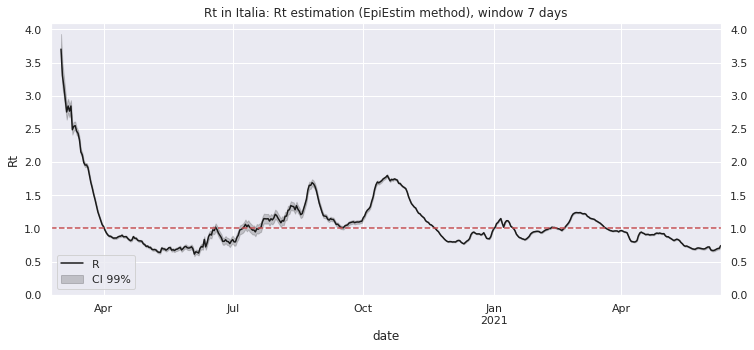

In [11]:
Rt = epi_estim_Rt(
    cov.nuovi_positivi, 
    SI_sh=ISS_sh, 
    SI_ra=ISS_ra, 
    window=7, 
    plot_Rt=True,
    title='Rt in Italia'
)

In [12]:
vax_pct = vax_cum[['prima_dose', 'seconda_dose']] / pop_it * 100

In [13]:
Rt_vax = Rt.merge(
    vax_pct,
    left_index=True, right_index=True
)

In [14]:
Rt_vax.loc[Rt_vax.seconda_dose==0, 'seconda_dose'] = np.nan

In [15]:
Rt_vax['prima_dose_pct'] = Rt_vax.prima_dose / 100
Rt_vax['seconda_dose_pct'] = Rt_vax.seconda_dose / 100

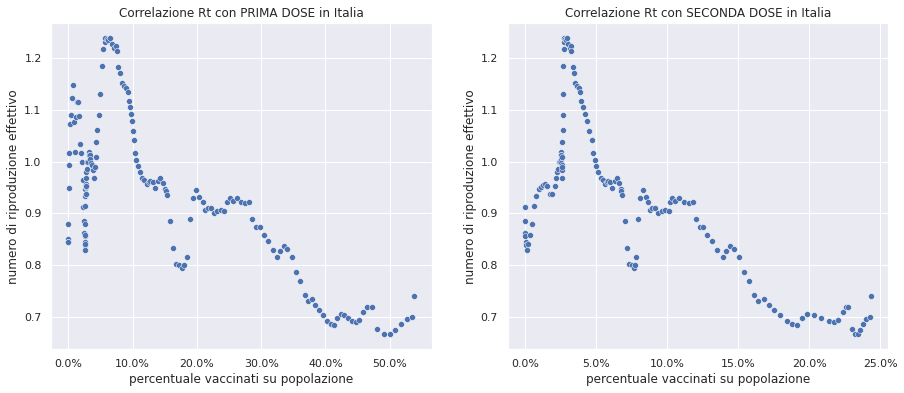

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=Rt_vax,
    x='prima_dose_pct', y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ax=ax[0]
)
ax[0].set(
    title='Correlazione Rt con PRIMA DOSE in Italia',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1,1))

sns.scatterplot(
    data=Rt_vax,
    x='seconda_dose_pct', y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ax=ax[1]
)
ax[1].set(
    title='Correlazione Rt con SECONDA DOSE in Italia',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1,1))

plt.show()

# Mondo

In [17]:
vax_www = pd.read_csv(
    'https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv',
    parse_dates=['date']
)

In [18]:
cov_www = pd.read_csv(
    'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
)

In [19]:
vax_cols = ['location', 'date', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']

In [20]:
errors = []
RT_VAX = None
for country in cov_www['Country/Region'].unique():
    vax_country = country
    if country == 'US':
        vax_country = 'United States'
    if country == 'Korea, South':
        vax_country = 'South Korea'
    if vax_country not in vax_www.location.values:
        errors.append(vax_country)
        continue
    _cov = cov_www[cov_www['Country/Region']==country].sum()
    _I = pd.DataFrame(_cov.T[4:]).diff()[1:]
    _I.columns = ['incidence']
    _I.index = pd.to_datetime(_I.index)
    _I.index.name = 'date'
    _I = _I.astype(int)
    Rt = epi_estim_Rt(
        _I, 
        SI_sh=ISS_sh, 
        SI_ra=ISS_ra, 
        window=7, 
        plot_Rt=False,
    )
    _merge = vax_www[vax_www.location==vax_country][vax_cols].merge(
        Rt,
        left_on='date', right_index=True
    )
    if RT_VAX is None:
        RT_VAX = _merge
    else:
        RT_VAX = RT_VAX.append(_merge)

In [21]:
countries = RT_VAX.location.unique()

In [22]:
RT_VAX.loc[RT_VAX.R<0, 'R'] = np.nan

In [23]:
RT_VAX.dropna(subset=['R'], inplace=True)

In [24]:
RT_VAX.dropna(subset=[
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred'
], inplace=True)

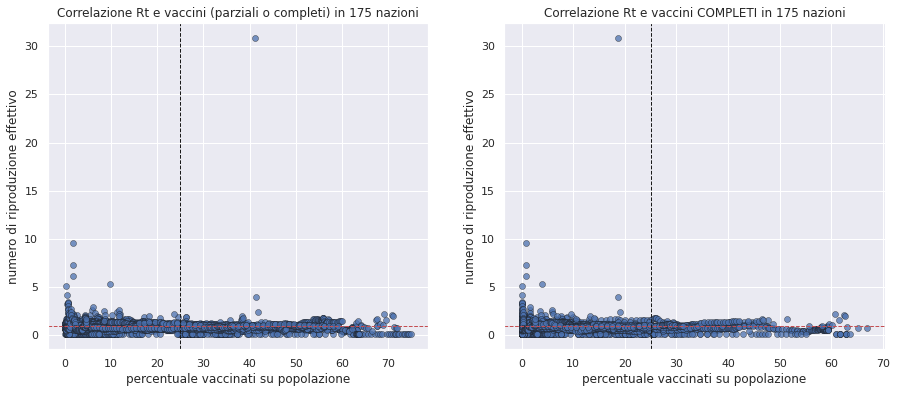

In [25]:
min_pct_partial = 25
min_pct_full = 25

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=RT_VAX,
    x='people_vaccinated_per_hundred',
    y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[0]
)
ax[0].axhline(1, color='r', ls='--', lw=1)
ax[0].axvline(min_pct_partial, color='k', ls='--', lw=1)
ax[0].set(
    title=f'Correlazione Rt e vaccini (parziali o completi) in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)

sns.scatterplot(
    data=RT_VAX,
    x='people_fully_vaccinated_per_hundred',
    y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[1]
)
ax[1].axhline(1, color='r', ls='--', lw=1)
ax[1].axvline(min_pct_full, color='k', ls='--', lw=1)
ax[1].set(
    title=f'Correlazione Rt e vaccini COMPLETI in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
plt.show()

In [26]:
for c in RT_VAX.location.unique():
    _c_partial = RT_VAX[(RT_VAX.location==c)&(RT_VAX.people_vaccinated_per_hundred>=min_pct_partial)]
    _c_full = RT_VAX[(RT_VAX.location==c)&(RT_VAX.people_fully_vaccinated_per_hundred>=min_pct_full)]
    _cR_partial = _c_partial.R.values.ravel()
    _cR_full = _c_full.R.values.ravel()
    if _cR_partial.size:
        Rt0_partial = _cR_partial[0]
        RT_VAX.loc[
            (RT_VAX.location==c)&(RT_VAX.people_vaccinated_per_hundred>=min_pct_partial)
            , 'R_var_min_partial'] = RT_VAX.R - Rt0_partial
    if _cR_full.size:
        Rt0_full = _cR_full[0]
        RT_VAX.loc[
            (RT_VAX.location==c)&(RT_VAX.people_fully_vaccinated_per_hundred>=min_pct_full)
            , 'R_var_min_full'] = RT_VAX.R - Rt0_full

# Regressione

Dalla formula per il calcolo della minima copertura vaccinale $V$

$$
V = \frac{1 - \frac{1}{R_0}}{E}
$$

dove $E$ è l'efficacia vaccinale ed $R_0$ è il numero di riproduzione di base, otteniamo che

$$
1 = R_0(1 - VE)
$$

ovvero il numero di riproduzione effettivo è $1$ al raggiungimento della minima soglia vaccinale.

Pertanto, riformulando l'equazione in

$$
R_t = R_0 (1 - V_t E)
$$

dove $R_t$ è il numero di riproduzione effettivo e $V_t$ è la percentuale di popolazione vaccinata al tempo t, possiamo avere un'idea di come ci attendiamo che il numero di riproduzione vari in funzione della percentuale di popolazione vaccinata.

Riscrivendo l'equazione, possiamo calcolare intercetta e pendenza della retta

$$
R_t = R_0 - R_0 E \cdot V_t
$$

dove evidentemente $\alpha = R_0$ è l'intercetta e $\beta = -R_0 E$ è la pendenza.

In prima ipotesi, supporremo che qualunque sia il numero di riproduzione effettivo $R_{t_0,n}$ al tempo $t_0$ della nazione $n$ (dove $t_0$ è il tempo in cui $V_{t_0,n}$ è almeno superiore ad una soglia minima $V_*$) la relazione tra $R_{t*,n}$ e $V_{t,n}$ sia una retta con intercetta $\alpha$ e pendenza $\beta$

$$
R_{t*,n} = \alpha + \beta \cdot V_{t,n}
$$

dove $R_{t*,n} = R_t - R_{t_0,n}$

pertanto eseguiremo una regressione lineare semplice (Ordinary Least Squares) stimando $\hat{\alpha}$ e $\hat{\beta}$, aspettandoci che, a prescindere dal valore di $\hat{\alpha}$, la pendenza $\hat{\beta}$ tenda a $-R_0 E$ (rette parallele alla retta attesa).

Da $\hat{\beta}$ possiamo dunque stimare l'efficacia vaccinale $\hat{E}$

$$
\hat{E} = - \frac{\hat{\beta}}{R_0}
$$

In [27]:
V = np.linspace(0, 1, 100)
R0 = 3
E1 = .5
E2 = .95
Rc1 = R0 * (1 - V * E1)
Rc2 = R0 * (1 - V * E2)

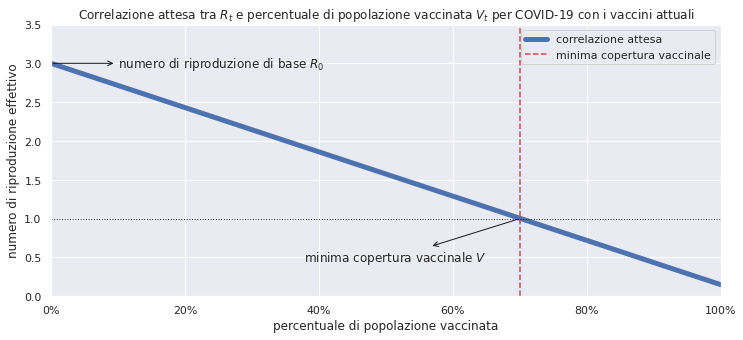

In [28]:
fgi, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    V, Rc2,
    label='correlazione attesa',
    lw=5
)
ax.axvline(.7, color='r', ls='--', label='minima copertura vaccinale')
ax.axhline(1, color='k', lw=1, ls=':')

ax.annotate(
    'numero di riproduzione di base $R_0$',
    xy=(0, 3),
    xytext=(.1, 3),
    ha='left', va='center',
    arrowprops=dict(color='k', arrowstyle='<-', lw=1)
)

ax.annotate(
    'minima copertura vaccinale $V$',
    xy=(.7, 1),
    xytext=(.65, .5),
    ha='right', va='center',
    arrowprops=dict(color='k', arrowstyle='<-', lw=1)
)

ax.set(
    ylim=(0, 3.5),
    xlim=(0, 1),
    xlabel='percentuale di popolazione vaccinata',
    ylabel='numero di riproduzione effettivo',
    title='Correlazione attesa tra $R_t$ e percentuale di popolazione vaccinata $V_t$'
    ' per COVID-19 con i vaccini attuali'
)
ax.legend()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,0))

In [29]:
beta_partial = - R0 * E1
beta_full = - R0 * E2

In [30]:
display(Markdown(fr"""
Prendendo come riferimento $R_0={R0}$ per COVID-19
e l'efficacia stimata degli attuali vaccini $E={E2*100:.0f}$%,
ci aspettiamo pertanto che, se l'efficacia vaccinale
è quella attesa, la pendenza della retta di regressione
lineare sia $\beta \simeq {beta_full:.3f}$

$$
R_t \simeq {R0} {beta_full:+.3f} \cdot V_t
$$

Come soglia minima $V_*$ per i vaccini sia completi che parziali
sceglieremo $V_*={min_pct_partial}$%.
"""))


Prendendo come riferimento $R_0=3$ per COVID-19
e l'efficacia stimata degli attuali vaccini $E=95$%,
ci aspettiamo pertanto che, se l'efficacia vaccinale
è quella attesa, la pendenza della retta di regressione
lineare sia $\beta \simeq -2.850$

$$
R_t \simeq 3 -2.850 \cdot V_t
$$

Come soglia minima $V_*$ per i vaccini sia completi che parziali
sceglieremo $V_*=25$%.


In [31]:
model_data_partial = RT_VAX[RT_VAX.people_vaccinated_per_hundred>=min_pct_partial].copy(deep=True)
model_data_partial['pct'] = model_data_partial.people_vaccinated_per_hundred / 100

model_data_full = RT_VAX[RT_VAX.people_fully_vaccinated_per_hundred>=min_pct_full].copy(deep=True)
model_data_full['pct'] = model_data_full.people_fully_vaccinated_per_hundred / 100

countries_partial = model_data_partial.location.unique()
countries_full = model_data_full.location.unique()

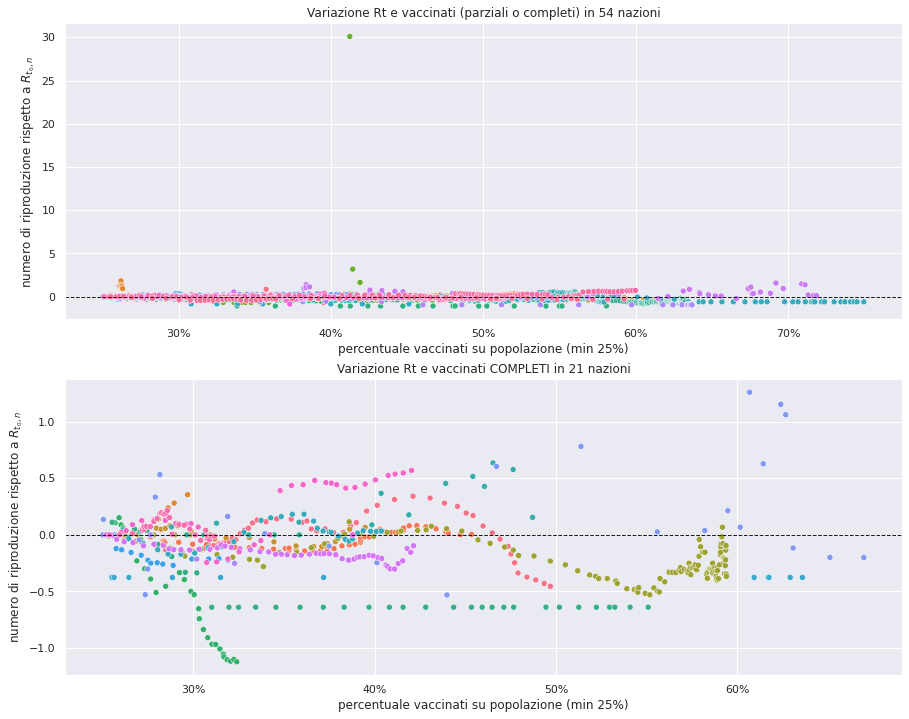

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.scatterplot(
    data=model_data_partial,
    x='pct',
    y='R_var_min_partial',
    hue='location',
    legend=False,
    ax=ax[0]
)
ax[0].axhline(0, color='k', ls='--', lw=1)
ax[0].set(
    title=f'Variazione Rt e vaccinati (parziali o completi) in {countries_partial.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct_partial}%)',
    ylabel='numero di riproduzione rispetto a $R_{t_0,n}$'
)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

sns.scatterplot(
    data=model_data_full,
    x='pct',
    y='R_var_min_full',
    hue='location',
    legend=False,
    ax=ax[1]
)
ax[1].axhline(0, color='k', ls='--', lw=1)
ax[1].set(
    title=f'Variazione Rt e vaccinati COMPLETI in {countries_full.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct_full}%)',
    ylabel='numero di riproduzione rispetto a $R_{t_0,n}$'
)
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

plt.show()

In [33]:
model_data_partial['pct_0'] = (model_data_partial.pct - model_data_partial.pct.values[0])

In [34]:
mod_partial = sm.OLS.from_formula(
    f'R_var_min_partial ~ pct_0 + 0', data=model_data_partial)
fit_partial = mod_partial.fit()

In [35]:
model_data_full['pct_0'] = (model_data_full.pct - model_data_full.pct.values[0])

In [36]:
mod_full = sm.OLS.from_formula('R_var_min_full ~ pct_0 + 0', data=model_data_full)
fit_full = mod_full.fit()

In [37]:
fit_partial_ci = fit_partial.conf_int(.05)

In [38]:
fit_full_ci = fit_full.conf_int(.05)

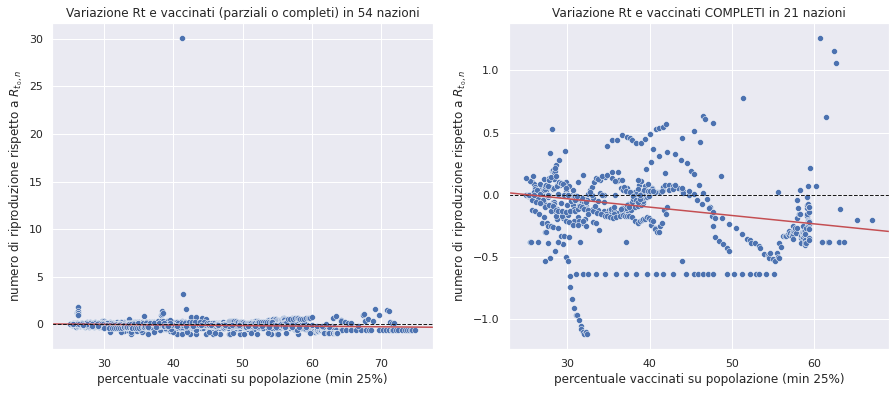

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=model_data_partial,
    x='people_vaccinated_per_hundred',
    y='R_var_min_partial',
    ax=ax[0]
)
ax[0].axline(xy1=(model_data_partial.pct.values[0]*100,0), slope=fit_partial.params.pct_0/100, color='r')
ax[0].axhline(0, color='k', ls='--', lw=1)
ax[0].set(
    title=f'Variazione Rt e vaccinati (parziali o completi) in {countries_partial.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct_partial}%)',
    ylabel='numero di riproduzione rispetto a $R_{t_0,n}$'
)

sns.scatterplot(
    data=model_data_full,
    x='people_fully_vaccinated_per_hundred',
    y='R_var_min_full',
    ax=ax[1]
)
ax[1].axhline(0, color='k', ls='--', lw=1)
ax[1].axline(xy1=(model_data_full.pct.values[0]*100,0), slope=fit_full.params.pct_0/100, color='r')
ax[1].set(
    title=f'Variazione Rt e vaccinati COMPLETI in {countries_full.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct_full}%)',
    ylabel='numero di riproduzione rispetto a $R_{t_0,n}$'
)
plt.show()

## Parziali o Completi

In [40]:
fit_partial.summary(alpha=.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      R_var_min_partial   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              38.09
Date:                Thu, 10 Jun 2021   Prob (F-statistic):                    8.23e-10
Time:                        18:04:23   Log-Likelihood:                         -2168.2
No. Observations:                1903   AIC:                                      4338.
Df Residuals:                    1902   BIC:                                      4344.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pct_0         -0.6299      0.102     -6.172      0.000      -0.830      -0.430
==============================================================================
Omnibus:                     5248.661   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        140793086.632
Skew:                          33.512   Prob(JB):                         0.00
Kurtosis:                    1333.843   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

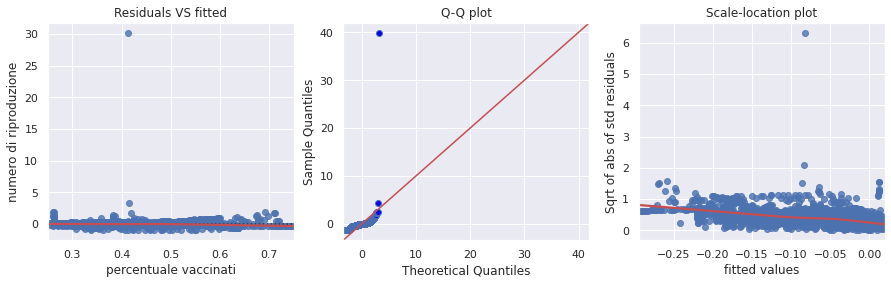

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.residplot(
    data=model_data_partial,
    x='pct', y='R_var_min_partial',
    lowess=True,
    line_kws=dict(color='r'),
    ax=ax[0]
)
ax[0].set(
    title='Residuals VS fitted',
    xlabel='percentuale vaccinati',
    ylabel='numero di riproduzione'
)

sm.qqplot(
    fit_partial.resid,
    fit=True,
    line='45',
    ax=ax[1]
)
ax[1].set(
    title='Q-Q plot'
)

mod_partial_residuals = fit_partial.get_influence().resid_studentized_internal
mod_partial_residuals_abs_sqrt = np.sqrt(np.abs(mod_partial_residuals))
sns.regplot(
    x=fit_partial.fittedvalues,
    y=mod_partial_residuals_abs_sqrt,
    lowess=True,
    line_kws=dict(color='r'),
    ax=ax[2]
)
ax[2].set(
    title='Scale-location plot',
    xlabel='fitted values',
    ylabel='Sqrt of abs of std residuals'
)

plt.show()

## Completi

In [42]:
fit_full.summary(alpha=.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         R_var_min_full   R-squared (uncentered):                   0.146
Model:                            OLS   Adj. R-squared (uncentered):              0.145
Method:                 Least Squares   F-statistic:                              100.3
Date:                Thu, 10 Jun 2021   Prob (F-statistic):                    6.80e-22
Time:                        18:04:27   Log-Likelihood:                         -92.290
No. Observations:                 586   AIC:                                      186.6
Df Residuals:                     585   BIC:                                      191.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pct_0         -0.6726      0.067    -10.014      0.000      -0.805      -0.541
==============================================================================
Omnibus:                       77.392   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.476
Skew:                           0.175   Prob(JB):                    5.14e-145
Kurtosis:                       8.205   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

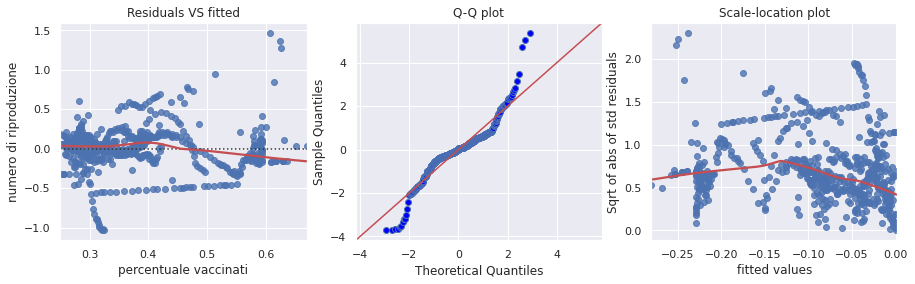

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.residplot(
    data=model_data_full,
    x='pct', y='R_var_min_full',
    lowess=True,
    line_kws=dict(color='r'),
    ax=ax[0]
)
ax[0].set(
    title='Residuals VS fitted',
    xlabel='percentuale vaccinati',
    ylabel='numero di riproduzione'
)

sm.qqplot(
    fit_full.resid,
    fit=True,
    line='45',
    ax=ax[1]
)
ax[1].set(
    title='Q-Q plot'
)

mod_full_residuals = fit_full.get_influence().resid_studentized_internal
mod_full_residuals_abs_sqrt = np.sqrt(np.abs(mod_full_residuals))
sns.regplot(
    x=fit_full.fittedvalues,
    y=mod_full_residuals_abs_sqrt,
    lowess=True,
    line_kws=dict(color='r'),
    ax=ax[2]
)
ax[2].set(
    title='Scale-location plot',
    xlabel='fitted values',
    ylabel='Sqrt of abs of std residuals'
)

plt.show()

# Risultati

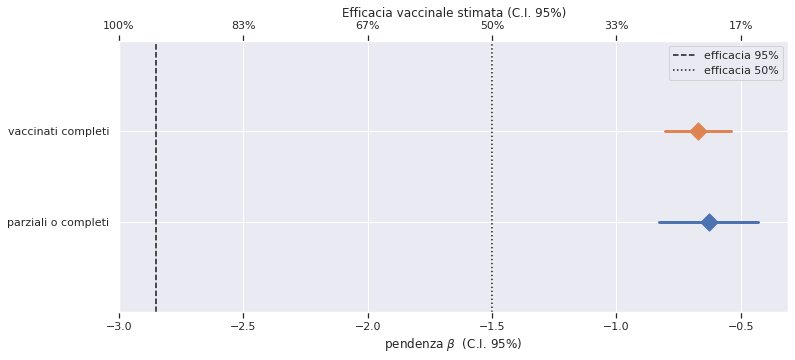

In [44]:
CI = .95

y0 = 'parziali o completi'
y1 = 'vaccinati completi'

fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(fit_partial.params.pct_0, y0, s=150, marker='D')
ax.plot(
    fit_partial.conf_int(alpha=1-CI).loc['pct_0'].values,
    [y0, y0], lw=3
)
ax.scatter(fit_full.params.pct_0, y1, s=150, marker='D')
ax.plot(
    fit_full.conf_int(alpha=1-CI).loc['pct_0'].values,
    [y1, y1], lw=3
)

#ax.axvline(beta_partial, color='C0', ls='--', label='pendenza attesa prima dose')
ax.axvline(beta_full, color='k', ls='--', label=f'efficacia {E2:.0%}')
ax.axvline(beta_partial, color='k', ls=':', label=f'efficacia {E1:.0%}')

ax.set(
    #yticks=[],
    ylim=(-1, 2),
    xlabel=fr'pendenza $\beta$  (C.I. {CI:.0%})',
    xlim=(-3, ax.get_xlim()[1])
)

ax1 = ax.twiny()
ax1.set(
    xlabel=fr'Efficacia vaccinale stimata (C.I. {CI:.0%})',
    xticks=ax.get_xticks(),
    xlim=ax.get_xlim(),
    xticklabels=[f"{i:.0%}" for i in (-ax.get_xticks() / R0)]
)
ax1.grid(alpha=0)

ax.legend()
plt.show()

# Nazioni

Nazioni totali nel dataset

In [45]:
print('NAZIONI dataset generale')
print('========================')
for i, c in enumerate(countries):
    print(f"{i+1:02d}", c)

NAZIONI dataset generale
01 Afghanistan
02 Albania
03 Algeria
04 Andorra
05 Angola
06 Antigua and Barbuda
07 Argentina
08 Armenia
09 Australia
10 Austria
11 Azerbaijan
12 Bahamas
13 Bahrain
14 Bangladesh
15 Barbados
16 Belarus
17 Belgium
18 Belize
19 Benin
20 Bhutan
21 Bolivia
22 Bosnia and Herzegovina
23 Botswana
24 Brazil
25 Brunei
26 Bulgaria
27 Burkina Faso
28 Cambodia
29 Cameroon
30 Canada
31 Central African Republic
32 Chile
33 China
34 Colombia
35 Comoros
36 Costa Rica
37 Cote d'Ivoire
38 Croatia
39 Cuba
40 Cyprus
41 Czechia
42 Denmark
43 Djibouti
44 Dominica
45 Dominican Republic
46 Ecuador
47 Egypt
48 El Salvador
49 Equatorial Guinea
50 Estonia
51 Eswatini
52 Ethiopia
53 Fiji
54 Finland
55 France
56 Gabon
57 Gambia
58 Georgia
59 Germany
60 Ghana
61 Greece
62 Grenada
63 Guatemala
64 Guinea
65 Guinea-Bissau
66 Guyana
67 Honduras
68 Hungary
69 Iceland
70 India
71 Indonesia
72 Iran
73 Iraq
74 Ireland
75 Israel
76 Italy
77 Jamaica
78 Japan
79 Jordan
80 Kazakhstan
81 Kenya
82 South 

Nazioni scelte per la regressione lineare

In [46]:
print('NAZIONI vaccini generali')
print('========================')
for i, c in enumerate(model_data_partial.location.unique()):
    print(f"{i+1:02d}", c)

NAZIONI vaccini generali
01 Andorra
02 Antigua and Barbuda
03 Argentina
04 Austria
05 Bahrain
06 Barbados
07 Belgium
08 Canada
09 Chile
10 Croatia
11 Cyprus
12 Czechia
13 Denmark
14 Dominica
15 Dominican Republic
16 Estonia
17 Finland
18 France
19 Germany
20 Greece
21 Guyana
22 Hungary
23 Iceland
24 Ireland
25 Israel
26 Italy
27 Latvia
28 Liechtenstein
29 Lithuania
30 Luxembourg
31 Maldives
32 Malta
33 Monaco
34 Mongolia
35 Morocco
36 Netherlands
37 Norway
38 Poland
39 Portugal
40 Qatar
41 Saint Kitts and Nevis
42 San Marino
43 Serbia
44 Seychelles
45 Singapore
46 Slovakia
47 Slovenia
48 Spain
49 Sweden
50 Switzerland
51 United States
52 United Arab Emirates
53 United Kingdom
54 Uruguay


In [47]:
print('NAZIONI vaccini completi')
print('========================')
for i, c in enumerate(model_data_full.location.unique()):
    print(f"{i+1:02d}", c)

NAZIONI vaccini completi
01 Bahrain
02 Chile
03 Cyprus
04 Hungary
05 Iceland
06 Israel
07 Liechtenstein
08 Lithuania
09 Maldives
10 Malta
11 Monaco
12 Mongolia
13 Qatar
14 San Marino
15 Serbia
16 Seychelles
17 Singapore
18 United States
19 United Arab Emirates
20 United Kingdom
21 Uruguay


***

Nazioni con errori, mancata corrispondenza o informazioni insufficienti:

In [48]:
print('NAZIONI con errori')
print('==================')
for i, c in enumerate(errors):
    print(f"{i+1:02d}", c)

NAZIONI con errori
01 Burma
02 Burundi
03 Cabo Verde
04 Chad
05 Congo (Brazzaville)
06 Congo (Kinshasa)
07 Diamond Princess
08 Eritrea
09 Haiti
10 Holy See
11 Kiribati
12 MS Zaandam
13 Marshall Islands
14 Micronesia
15 Taiwan*
16 Tanzania
17 Timor-Leste
18 West Bank and Gaza
